In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import rebound as rb
from tqdm import tqdm
from scipy import stats

In [2]:
# plotting style
import matplotlib as mpl
from matplotlib import rc
mpl.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':30})
rc('text', usetex=True)

mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25)
mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25)

mpl.rcParams['xtick.major.size'] = 6.0
mpl.rcParams['xtick.major.width'] = 2.5
mpl.rcParams['ytick.major.size'] = 6.0
mpl.rcParams['ytick.major.width'] = 2.5

mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['patch.linewidth'] = 2.0
mpl.rcParams['xtick.major.pad'] = 14.0
mpl.rcParams['ytick.major.pad'] = 14.0

mpl.rcParams['xtick.top'] = False
mpl.rcParams['ytick.right'] = False

mpl.rcParams['xtick.minor.size'] = 4.5
mpl.rcParams['xtick.minor.width'] = 1.25
mpl.rcParams['ytick.minor.size'] = 4.5
mpl.rcParams['ytick.minor.width'] = 1.25

import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

# Load REBOUND simulation archives

In [3]:
filename = "giant_impact_Nbody_sims"
Nbody_all_sim_archives = []
for i in range(500):
    Nbody_all_sim_archives.append(rb.Simulationarchive("Data/" + filename + "/sa" + str(i) + ".bin"))

/Users/cl5968/anaconda3/lib/python3.11/site-packages/rebound/simulationarchive.py:95: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


In [4]:
filename = "giant_impact_ML_preds"
ML_all_sim_archives = []
for i in range(500):
    ML_all_sim_archives.append(rb.Simulationarchive("Data/" + filename + "/sa" + str(i) + ".bin"))

# Get system properties 

In [5]:
# returns copy of sim object with ejected planets (i.e., planets with a > 50 a1) removed
def remove_ejected(sim):
    sim_copy = sim.copy()
    for i in range(len(sim_copy.particles)):
        sim_copy.particles[i].hash = str(i)
    
    ps = sim.particles
    for i in range(1, len(ps)):
        if (not 0.0 < ps[i].a < 5.0) or (not 0.0 < ps[i].e < 1.0): #5 instead of 50 because a1=0.1
            sim_copy.remove(hash=str(i))
    
    #remove hashes
    for i in range(len(sim_copy.particles)):
        sim_copy.particles[i].hash = 0
        
    return sim_copy

In [6]:
# function to get 1D list of planet masses (in Earth masses) from a list of REBOUND simulation archives
def get_masses(sim_archives, ind=-1):
    final_masses = []
    for i in range(len(sim_archives)): #Go through each system
        sim = remove_ejected(sim_archives[i][ind])
        for k in range(1, len(sim.particles)):
            final_masses.append(sim.particles[k].m)
            
    return np.array(final_masses)/3e-6

In [7]:
# function to get 1D list of adjacent-planet period ratios from a list of REBOUND simulation archives
def get_period_ratios(sim_archives, ind=-1):
    final_period_ratios = []
    for i in range(len(sim_archives)): #Go through each system
        sim = remove_ejected(sim_archives[i][ind])
        periods = []
        for k in range(1, len(sim.particles)):
            periods.append(sim.particles[k].P)
            
        sorted_periods = np.sort(periods)
        for k in range(len(sorted_periods)-1):
            final_period_ratios.append(sorted_periods[k+1]/sorted_periods[k])

    return np.array(final_period_ratios)

In [8]:
# function to get 1D list of orbital inclinations (in degrees) from a list of REBOUND simulation archives
def get_incs(sim_archives, ind=-1):
    incs = []
    for i in range(len(sim_archives)): #Go through each system
        sim = remove_ejected(sim_archives[i][ind])
        for k in range(1, len(sim.particles)):
            incs.append(sim.particles[k].inc)
            
    return np.array(incs)*(180.0/np.pi)

In [9]:
# function to calculate the mass partition Q for a list of REBOUND simulation archives
def get_mass_partition(sim_archives, ind=-1):
    Qs = []
    for i in range(len(sim_archives)): #Go through each system
        sim = remove_ejected(sim_archives[i][ind])
        N_pl = len(sim.particles) - 1
        tot_pl_mass = 0.0
        for k in range(1, len(sim.particles)):
            tot_pl_mass += sim.particles[k].m
        
        Q_val = 0.0
        for k in range(1, len(sim.particles)):
            Q_val += (N_pl/(N_pl - 1))*(sim.particles[k].m/tot_pl_mass - 1/N_pl)**2
        Qs.append(Q_val)
            
    return np.array(Qs)

In [10]:
# function to get C_max when provided the number of gaps n (= Npl - 1) (from Table 2 in Gilbert & Fabrycky)
def get_C_max(n):
    if n == 2:
        return 0.106
    elif n == 3:
        return 0.212
    elif n == 4:
        return 0.291
    elif n == 5:
        return 0.350
    elif n == 6:
        return 0.398
    elif n == 7:
        return 0.437
    elif n == 8:
        return 0.469
    elif n == 9:
        return 0.497

In [11]:
# function to calculate the gap complexity C for a list of REBOUND simulation archives
def get_gap_complexity(sim_archives, ind=-1):
    Cs = []
    for i in range(len(sim_archives)): #Go through each system
        sim = remove_ejected(sim_archives[i][ind])
        orb_periods = []
        for k in range(1, len(sim.particles)):
            orb_periods.append(sim.particles[k].P)
            
        if len(orb_periods) < 3:
            Cs.append(-1.0)
        
        else:
            entropy_val, diseq_val = 0.0, 0.0
            sorted_periods = np.sort(orb_periods)
            min_perod, max_period = sorted_periods[0], sorted_periods[-1]
            n_gaps = len(sorted_periods) - 1
            C_max = get_C_max(n_gaps)
            for k in range(n_gaps):
                p_i_ast = np.log(sorted_periods[k+1]/sorted_periods[k])/np.log(max_period/min_perod)
                entropy_val += p_i_ast*np.log(p_i_ast)
                diseq_val += (p_i_ast - 1/n_gaps)**2
            C_val = -(1/C_max)*entropy_val*diseq_val
            Cs.append(C_val)
        
    return np.array(Cs)

In [12]:
# function to calculate the gap complexity C for a list of REBOUND simulation archives
def get_NAMD(sim_archives, ind=-1):
    NAMDs = []
    for i in range(len(sim_archives)): #Go through each system
        sim = remove_ejected(sim_archives[i][ind])
        
        NAMD_val = 0.0
        ps = sim.particles
        for k in range(1, len(ps)):
            NAMD_val += ps[k].m*np.sqrt(ps[k].a)*(1 - np.cos(ps[k].inc))*np.sqrt(1 - ps[k].e**2)/(ps[k].m*np.sqrt(ps[k].a))
        NAMDs.append(NAMD_val)
    
    return np.array(NAMDs)

In [13]:
# remove two-planet systems (they present a problem for the gap complexity calculation + there are only a few of them)
Nbody_sim_archives = []
for i in range(len(Nbody_all_sim_archives)):
    sim = remove_ejected(Nbody_all_sim_archives[i][-1])
    if 2 < len(sim.particles):
        Nbody_sim_archives.append(Nbody_all_sim_archives[i])
        
# calculate planet-level properties for the N-body systems
Nbody_masses = get_masses(Nbody_sim_archives)
Nbody_period_ratios = get_period_ratios(Nbody_sim_archives)
Nbody_incs = get_incs(Nbody_sim_archives)

# calculate system-level properties for the N-body systems
Nbody_Cs = get_gap_complexity(Nbody_sim_archives)
Nbody_Cs = Nbody_Cs[(Nbody_Cs != -1)] # mask any bad C values (could occur due to, e.g., ejected particles)
Nbody_Qs = get_mass_partition(Nbody_sim_archives)
Nbody_NAMDs = get_NAMD(Nbody_sim_archives)

/Users/cl5968/anaconda3/lib/python3.11/site-packages/rebound/simulationarchive.py:142: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/cl5968/anaconda3/lib/python3.11/site-packages/rebound/simulationarchive.py:142: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [14]:
# remove two-planet systems (they present a problem for the gap complexity calculation + there are only a few of them)
ML_sim_archives = []
for i in range(len(ML_all_sim_archives)):
    sim = remove_ejected(ML_all_sim_archives[i][-1])
    if 2 < len(sim.particles):
        ML_sim_archives.append(ML_all_sim_archives[i])
        
# calculate planet-level properties for the N-body systems
ML_masses = get_masses(ML_sim_archives)
ML_period_ratios = get_period_ratios(ML_sim_archives)
ML_incs = get_incs(ML_sim_archives)

# calculate system-level properties for the N-body systems
ML_Cs = get_gap_complexity(ML_sim_archives)
ML_Cs = ML_Cs[(ML_Cs != -1)] # mask any bad C values (could occur due to, e.g., ejected particles)
ML_Qs = get_mass_partition(ML_sim_archives)
ML_NAMDs = get_NAMD(ML_sim_archives)

# Calculate Wasserstein distances

In [15]:
stats.wasserstein_distance(ML_masses, Nbody_masses)

1.4128745603529094

In [16]:
stats.wasserstein_distance(ML_period_ratios, Nbody_period_ratios)

0.46534325437098034

In [17]:
stats.wasserstein_distance(ML_incs, Nbody_incs)

2.245691660955166

In [18]:
stats.wasserstein_distance(ML_Qs, Nbody_Qs)

0.010561081995463751

In [19]:
stats.wasserstein_distance(ML_Cs, Nbody_Cs)

0.06899871950740635

In [20]:
stats.wasserstein_distance(100*ML_NAMDs, 100*Nbody_NAMDs)

2.0216494133049294

# 3 x 2 histogram plot

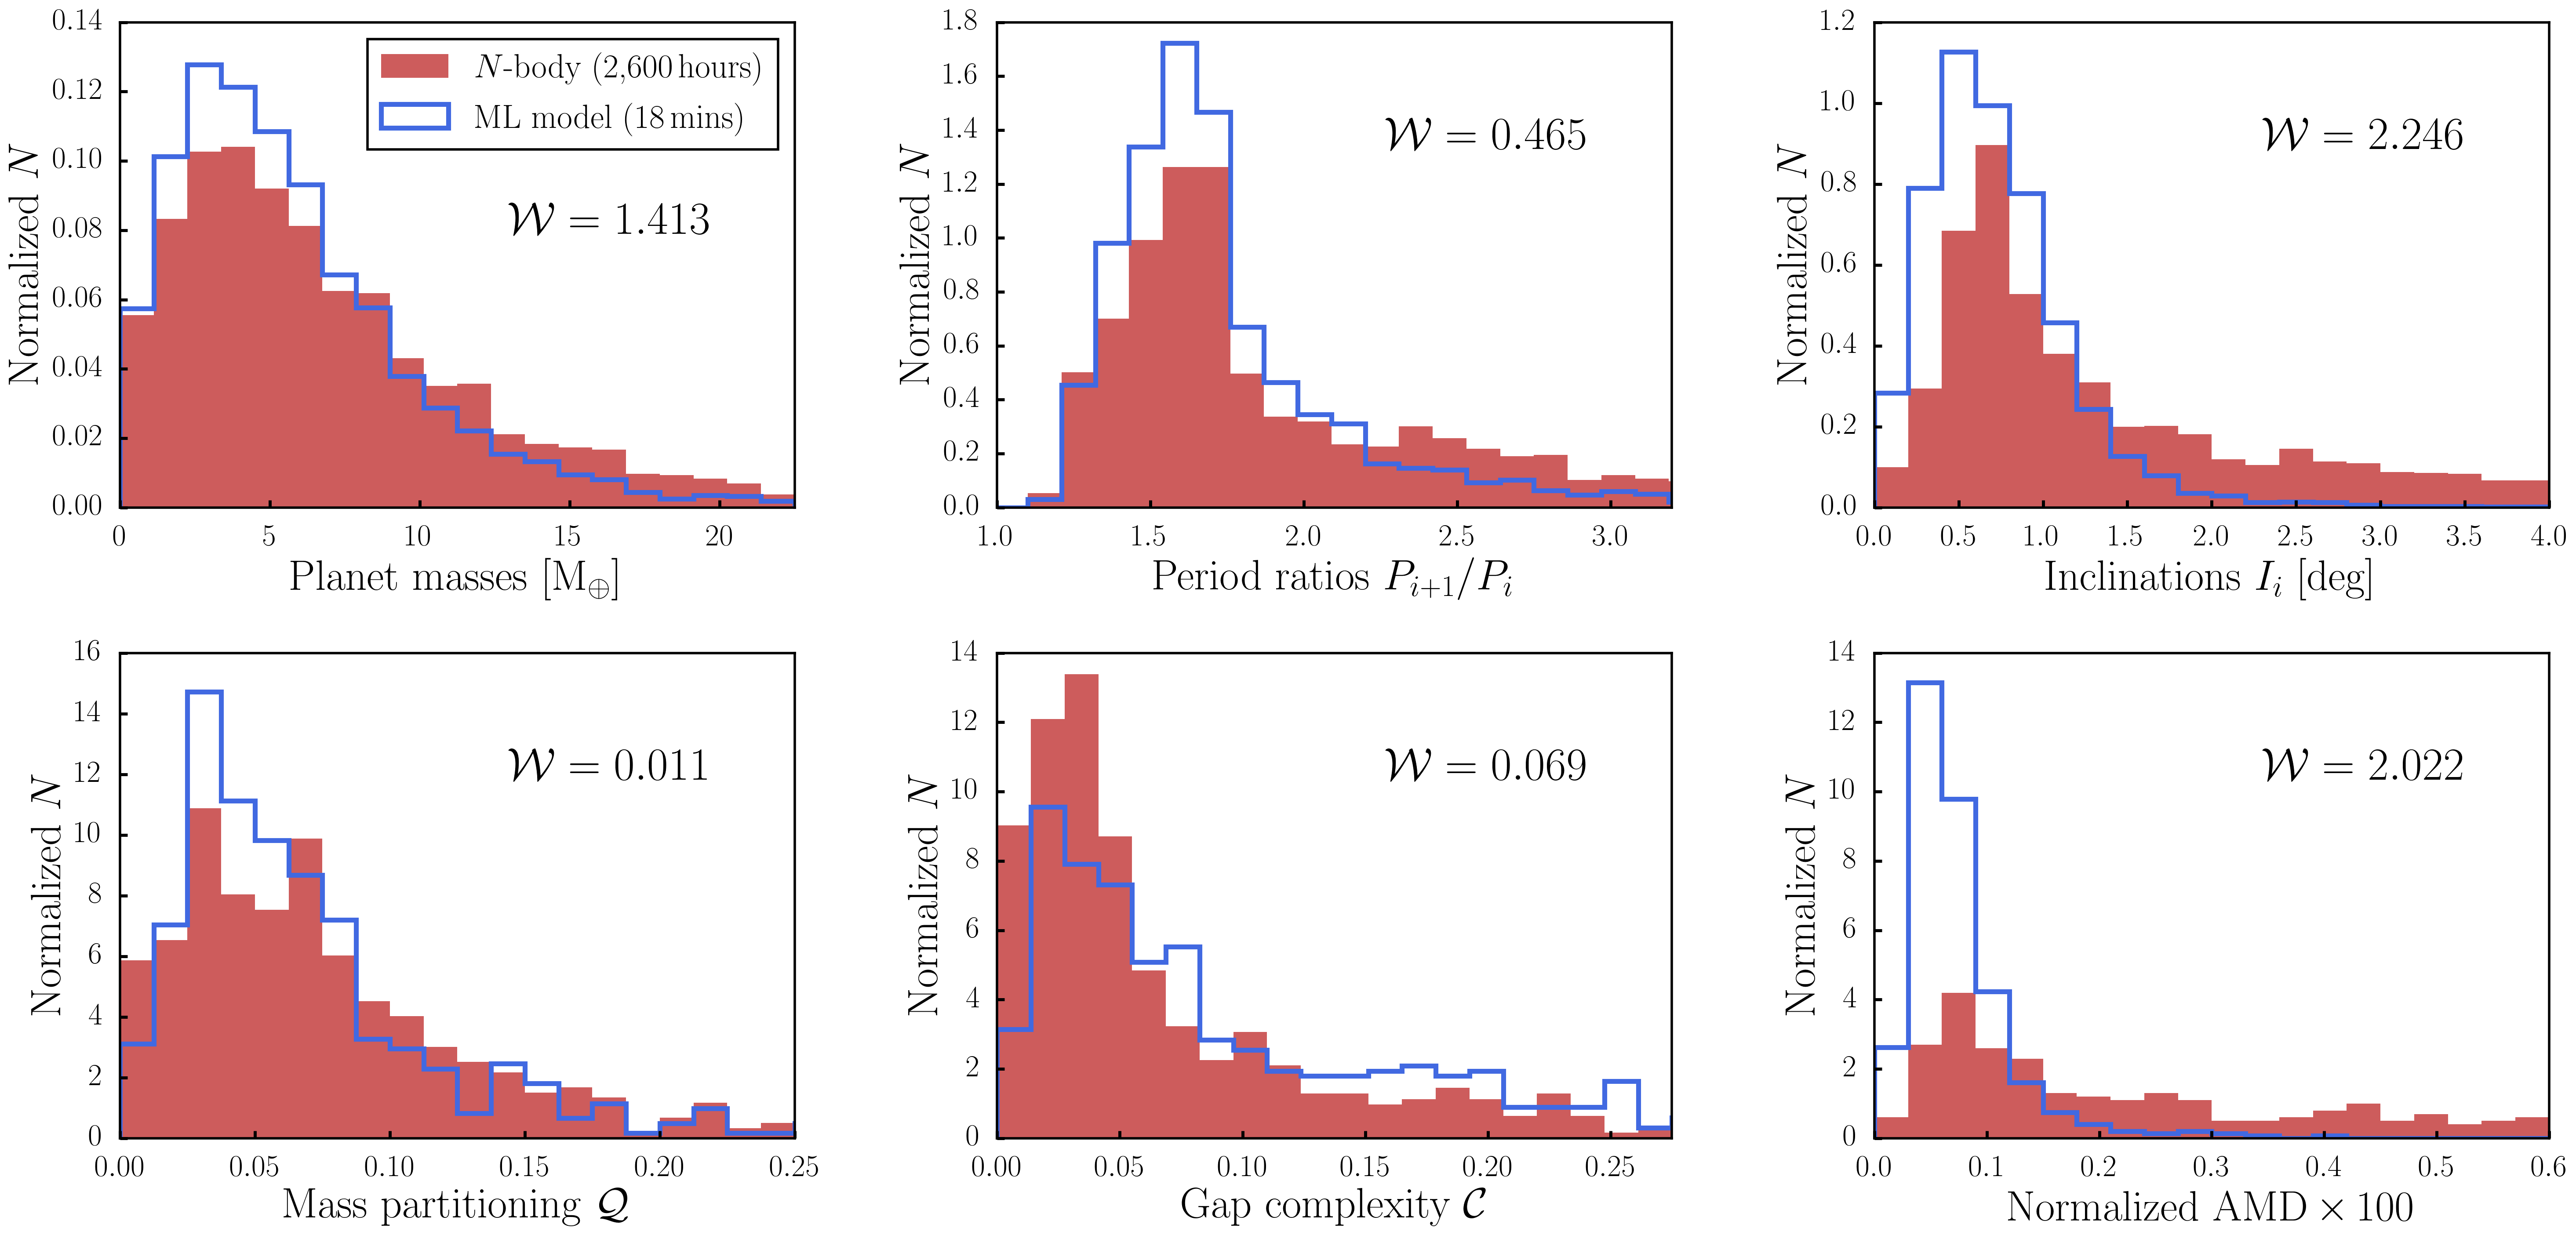

In [21]:
# plot parameters
num_bins = 20
xlim1, xlim2, xlim3 = 22.5, 3.2, 4.0
xlim4, xlim5, xlim6 = 0.25, 0.275, 0.6

# setup axes
fig, ax = plt.subplots(2, 3, figsize=(30.0,14.75), facecolor='white', dpi=200)

ax[0,0].hist(Nbody_masses, bins=np.arange(0.0, 35.0, (xlim1-0.0)/num_bins), color='indianred', lw=0.0, density=True, label='$N$-body ($2$,$600$\,hours)')
ax[0,0].hist(ML_masses, bins=np.arange(0.0, 35.0, (xlim1-0.0)/num_bins), color='royalblue', histtype='step', lw=4.0, density=True, label='ML model ($18$\,mins)')
ax[0,0].set_xlabel(r'Planet masses [M$_{\oplus}$]', fontsize=35, labelpad=5)
ax[0,0].set_ylabel(r'Normalized $N$', fontsize=35, labelpad=5)
ax[0,0].set_xlim([0.0, xlim1])
ax[0,0].legend(fontsize=27.5, loc='upper right')

ax[0,1].hist(Nbody_period_ratios, bins=np.arange(0.0, 10.0, (xlim2-1.0)/num_bins), color='indianred', lw=0.0, density=True, label='True $N$-body (${\sim}\,500$\,hours)')
ax[0,1].hist(ML_period_ratios, bins=np.arange(0.0, 10.0, (xlim2-1.0)/num_bins), color='royalblue', histtype='step', lw=4.0, density=True, label='ML MLiction (${\sim}\,3$\,mins)')
ax[0,1].set_xlabel(r'Period ratios $P_{i+1}/P_{i}$', fontsize=35, labelpad=5)
ax[0,1].set_ylabel(r'Normalized $N$', fontsize=35, labelpad=5)
ax[0,1].set_xlim([1.0, xlim2])

ax[0,2].hist(Nbody_incs, bins=np.arange(0.0, 5.0, (xlim3-0.0)/num_bins), color='indianred', lw=0.0, density=True, label='True $N$-body (${\sim}\,500$\,hours)')
ax[0,2].hist(ML_incs, bins=np.arange(0.0, 5.0, (xlim3-0.0)/num_bins), color='royalblue', histtype='step', lw=4.0, density=True, label='ML MLiction (${\sim}\,3$\,mins)')
ax[0,2].set_xlabel(r'Inclinations $I_i$ [deg]', fontsize=35, labelpad=5)
ax[0,2].set_ylabel(r'Normalized $N$', fontsize=35, labelpad=5)
ax[0,2].set_xlim([0.0, xlim3])

ax[1,0].hist(Nbody_Qs, bins=np.arange(0.0, 0.30, (xlim4-0.0)/num_bins), color='indianred', lw=0.0, density=True, label='$N$-body ($7$,$500$\,hours)')
ax[1,0].hist(ML_Qs, bins=np.arange(0.0, 0.30, (xlim4-0.0)/num_bins), color='royalblue', histtype='step', lw=4.0, density=True, label='ML model ($36$\,mins)')
ax[1,0].set_xlabel(r'Mass partitioning $\mathcal{Q}$', fontsize=35, labelpad=5)
ax[1,0].set_ylabel(r'Normalized $N$', fontsize=35, labelpad=5)
ax[1,0].set_xlim([0.0, xlim4])

ax[1,1].hist(Nbody_Cs, bins=np.arange(0.0, 0.80, (xlim5-0.0)/num_bins), color='indianred', lw=0.0, density=True, label='$N$-body ($7$,$500$\,hours)')
ax[1,1].hist(ML_Cs, bins=np.arange(0.0, 0.80, (xlim5-0.0)/num_bins), color='royalblue', histtype='step', lw=4.0, density=True, label='ML model ($36$\,mins)')
ax[1,1].set_xlabel(r'Gap complexity $\mathcal{C}$', fontsize=35, labelpad=5)
ax[1,1].set_ylabel(r'Normalized $N$', fontsize=35, labelpad=5)
ax[1,1].set_xlim([0.0, xlim5])

ax[1,2].hist(100*Nbody_NAMDs, bins=np.arange(0.0, 1.5, (xlim6-0.0)/num_bins), color='indianred', lw=0.0, density=True, label='$N$-body ($7$,$500$\,hours)')
ax[1,2].hist(100*ML_NAMDs, bins=np.arange(0.0, 1.5, (xlim6-0.0)/num_bins), color='royalblue', histtype='step', lw=4.0, density=True, label='ML model ($36$\,mins)')
ax[1,2].set_xlabel(r'Normalized AMD$\,\times\,100$', fontsize=35, labelpad=5)
ax[1,2].set_ylabel(r'Normalized $N$', fontsize=35, labelpad=5)
ax[1,2].set_xlim([0.0, xlim6])

ax[0,0].text(0.575*xlim1, 0.625*0.14, r'$\mathcal{W} = 1.413$', color = 'k', fontsize=37.5, horizontalalignment='left', verticalalignment='top')
ax[0,1].text(1.0+0.575*(xlim2-1.0), 0.80*1.8, r'$\mathcal{W} = 0.465$', color = 'k', fontsize=37.5, horizontalalignment='left', verticalalignment='top')
ax[0,2].text(0.575*xlim3, 0.80*1.2, r'$\mathcal{W} = 2.246$', color = 'k', fontsize=37.5, horizontalalignment='left', verticalalignment='top')

ax[1,0].text(0.575*xlim4, 0.80*16, r'$\mathcal{W} = 0.011$', color = 'k', fontsize=37.5, horizontalalignment='left', verticalalignment='top')
ax[1,1].text(0.575*xlim5, 0.80*14, r'$\mathcal{W} = 0.069$', color = 'k', fontsize=37.5, horizontalalignment='left', verticalalignment='top')
ax[1,2].text(0.575*xlim6, 0.80*14, r'$\mathcal{W} = 2.022$', color = 'k', fontsize=37.5, horizontalalignment='left', verticalalignment='top')

plt.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()